In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_exchange(name, lag_ms=0, seed=0, n_ticks=1000):
    np.random.seed(seed)
    timestamps = pd.date_range("2025-08-01", periods=n_ticks, freq="ms") + pd.Timedelta(milliseconds=lag_ms)
    prices = 100 + np.cumsum(np.random.normal(0, 0.03, size=n_ticks))
    sizes = np.random.randint(50, 200, size=n_ticks)
    return pd.DataFrame({
        "timestamp": timestamps,
        "price": prices,
        "size": sizes,
        "exchange": name
    })

fast_feed = simulate_exchange("Fast", lag_ms=0, seed=1)
slow_feed = simulate_exchange("Slow", lag_ms=3, seed=2)

In [2]:
combined_feed = pd.concat([fast_feed, slow_feed]).sort_values("timestamp").reset_index(drop=True)

In [3]:
class LatencyArbAgent:
    def __init__(self, threshold=0.25):
        self.threshold = threshold
        self.pnl = 0.0
        self.trades = []
        self.feed_buffer = []

    def observe(self, tick):
        self.feed_buffer.append(tick)
        if len(self.feed_buffer) < 2:
            return
        latest = self.feed_buffer[-1]
        prior = self.feed_buffer[-2]
        if latest["exchange"] != prior["exchange"]:
            price_diff = latest["price"] - prior["price"]
            if abs(price_diff) >= self.threshold:
                self.execute_arbitrage(buy=prior if price_diff > 0 else latest,
                                       sell=latest if price_diff > 0 else prior)

    def execute_arbitrage(self, buy, sell):
        size = min(buy["size"], sell["size"])
        profit = (sell["price"] - buy["price"]) * size
        self.pnl += profit
        self.trades.append({
            "timestamp": sell["timestamp"],
            "buy_price": buy["price"],
            "sell_price": sell["price"],
            "size": size,
            "pnl": profit
        })


In [4]:
agent = LatencyArbAgent(threshold=0.25)
for _, row in combined_feed.iterrows():
    agent.observe(row)


In [7]:
def display_metrics(agent):
    df = pd.DataFrame(agent.trades)
    if df.empty:
        print("No trades executed.")
        return

    win_rate = sum(df["pnl"] > 0) / len(df)
    sharpe = df["pnl"].mean() / df["pnl"].std() if df["pnl"].std() != 0 else 0
    print(f"Total Trades: {len(df)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Total PnL: ${agent.pnl:.2f}")
    print(f"Average Trade PnL: ${df['pnl'].mean():.2f}")
    print(f"Sharpe Ratio (approx): {sharpe:.2f}")

display_metrics(agent)


Total Trades: 1532
Win Rate: 100.00%
Total PnL: $217216.65
Average Trade PnL: $141.79
Sharpe Ratio (approx): 1.49


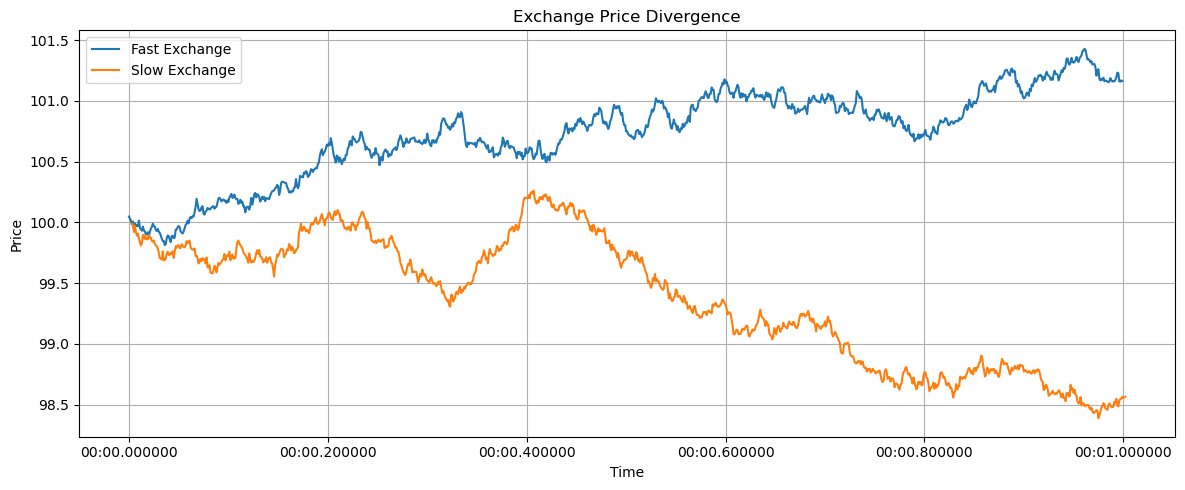

In [8]:
def plot_price_streams(fast, slow):
    plt.figure(figsize=(12, 5))
    plt.plot(fast["timestamp"], fast["price"], label="Fast Exchange")
    plt.plot(slow["timestamp"], slow["price"], label="Slow Exchange")
    plt.legend()
    plt.title("Exchange Price Divergence")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_price_streams(fast_feed, slow_feed)


- **Slippage & Execution Delay:**  
  In real markets, not all trades are filled at the observed price; adding a small slippage or execution delay would reduce PnL and increase risk.
- **Threshold Selection:**  
  Lower thresholds increase trade frequency but may generate more losing trades. Higher thresholds reduce trades but increase confidence in profitability.
- **Market Reality:**  
  Fragmented venues, order book depth, and real-time competition with other agents (and latency-sensitive HFTs) make consistent arbitrage difficult.
- **Leaderboard Extension:**  
  Comparing Sharpe ratios or cumulative PnL for multiple agents with different speed/logic gives insight into relative performance.
